## Exploring the data

In [1]:
import numpy as np
import cv2
import glob
from collections import deque
import matplotlib.pyplot as plt

import os
import random
import math

import scipy
from scipy import signal

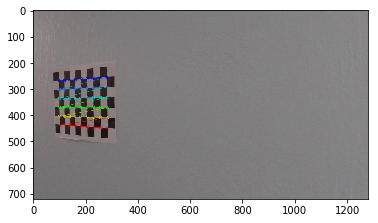

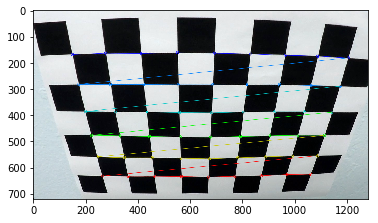

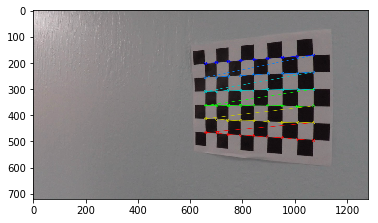

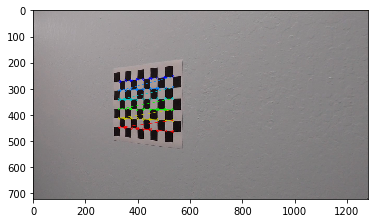

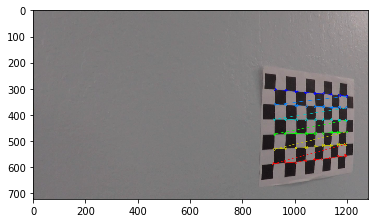

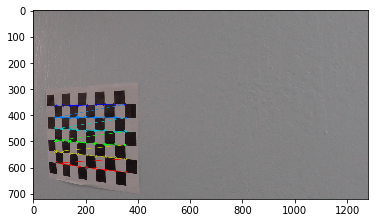

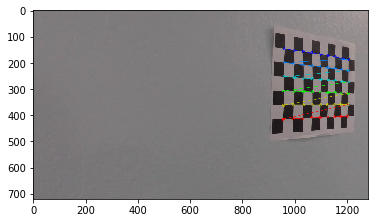

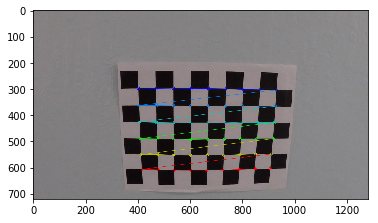

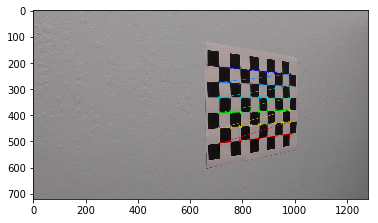

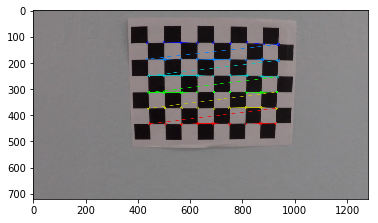

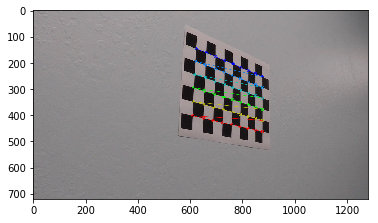

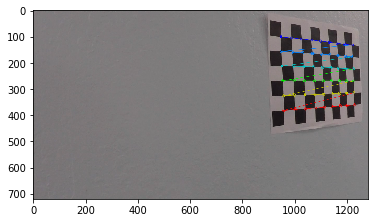

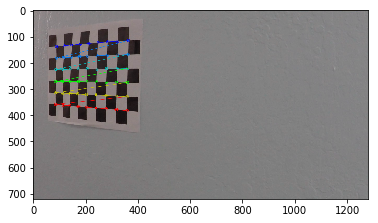

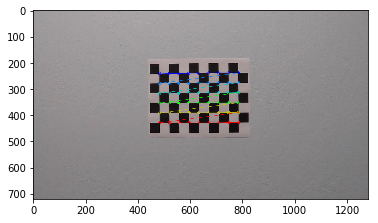

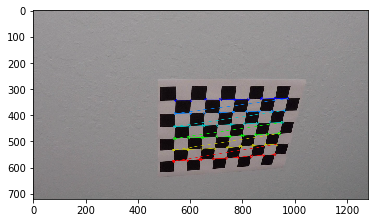

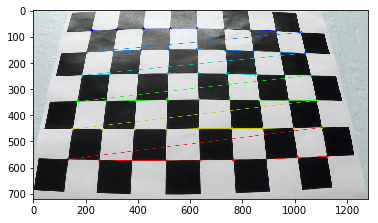

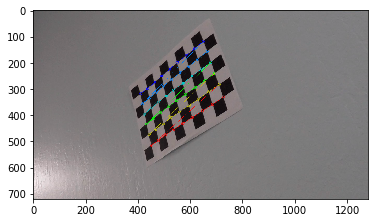

In [2]:

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img)
        plt.show()



In [3]:
test_images_dir = './test_images'
test_images = os.listdir(test_images_dir)
img_path = random.choice(test_images)
image = cv2.imread(os.path.join(test_images_dir, img_path))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

(720, 1280, 3)


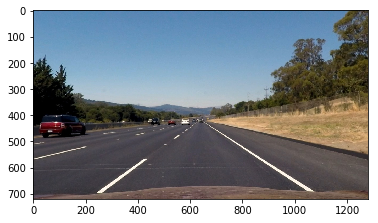

In [4]:

objpoints = objpoints
imgpoints = imgpoints

def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[:2], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

undistorted = cal_undistort(image, objpoints, imgpoints)
print(image.shape)

plt.imshow(undistorted)
plt.savefig('./images/undistorted.png')
plt.show()


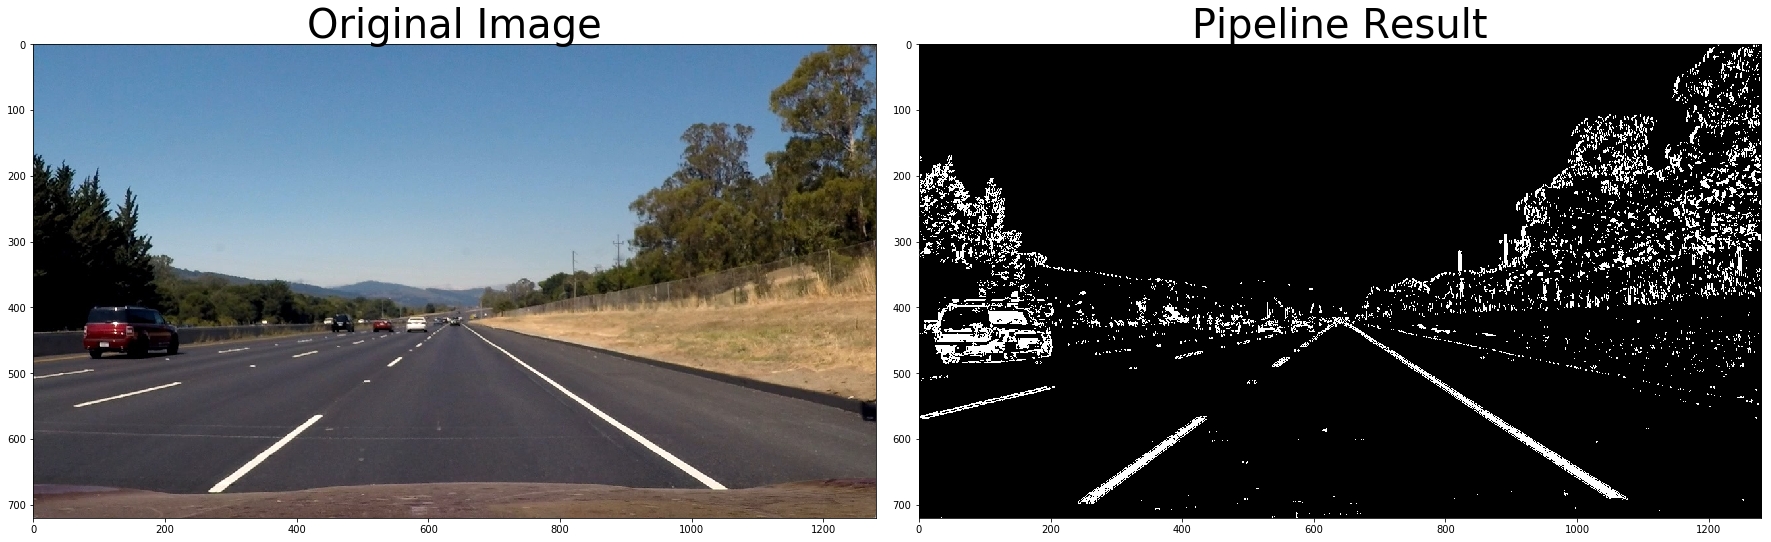

In [5]:

def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return combined_binary
    
result = pipeline(undistorted, s_thresh=(170, 255), sx_thresh=(20, 100))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()


ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.savefig('./images/sobel.png')
plt.show()

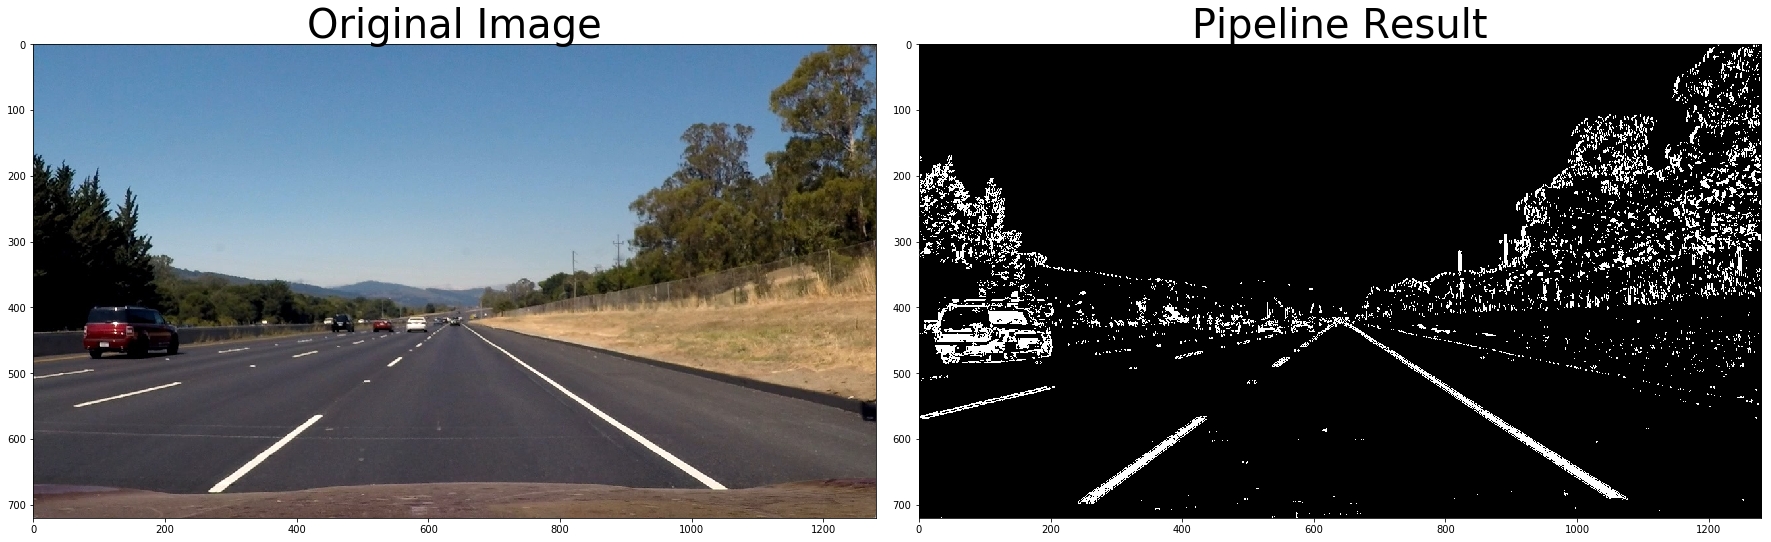

In [6]:
gradient = pipeline(undistorted, s_thresh=(130, 260), sx_thresh=(30, 100))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('./images/pipeline.png')
plt.show()

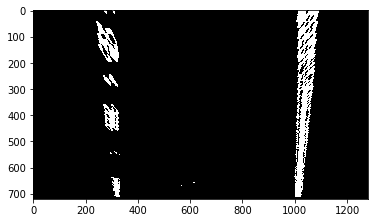

In [7]:
img_size = gradient.shape

src = np.array([[590. /1280.*img_size[1], 455./720.*img_size[0]],
                [690. /1280.*img_size[1], 455./720.*img_size[0]],
                [1090./1280.*img_size[1], 720./720.*img_size[0]],
                [190. /1280.*img_size[1], 720./720.*img_size[0]]], np.float32)

dst = np.array([[300. /1280.*img_size[1], 100./720.*img_size[0]],
                [1000./1280.*img_size[1], 100./720.*img_size[0]],
                [1000./1280.*img_size[1], 720./720.*img_size[0]],
                [300. /1280.*img_size[1], 720./720.*img_size[0]]], np.float32)



M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
warped = cv2.warpPerspective(gradient, M, (img_size[1], img_size[0]), flags=cv2.INTER_LINEAR)


plt.imshow(warped, cmap='gray')
plt.savefig('./images/warped.png')
plt.show()

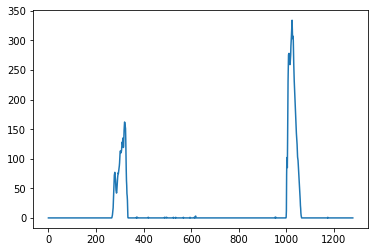

In [8]:
im_slice = int(warped.shape[0]/2)
histogram = np.sum(warped[im_slice:,:], axis=0)
plt.plot(histogram)
plt.savefig('./histogram.png')
plt.show()

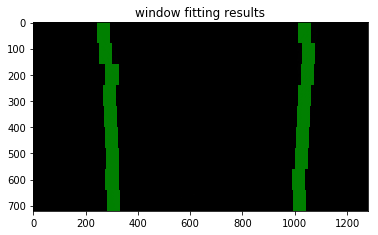

In [9]:
  
# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
	    # convolve the window into the vertical slice of the image
	    image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
	    conv_signal = np.convolve(window, image_layer)
	    # Find the best left centroid by using past left center as a reference
	    # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
	    offset = window_width/2
	    l_min_index = int(max(l_center+offset-margin,0))
	    l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
	    l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
	    # Find the best right centroid by using past right center as a reference
	    r_min_index = int(max(r_center+offset-margin,0))
	    r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
	    r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
	    # Add what we found for that layer
	    window_centroids.append((l_center,r_center))

    return window_centroids

window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)
    
    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
	    l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
	    r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
	    # Add graphic points from window mask here to total pixels found 
	    l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
	    r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channle 
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.savefig('./images/windows.png')
plt.show()

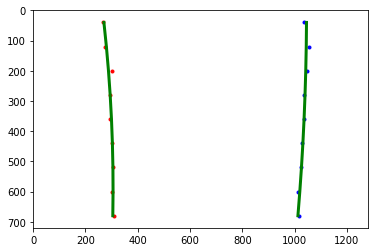

In [10]:
ploty = np.asarray([40, 120, 200, 280, 360, 440, 520, 600, 680])
l_points = []
r_points = []

y_values = [40, 120, 200, 280, 360, 440, 520, 600, 680] #
for l, r in window_centroids:
    l_points.append(l)
    r_points.append(r)

l_points = np.asarray(l_points[::-1])
r_points = np.asarray(r_points[::-1])

# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, l_points, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, r_points, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(l_points, ploty, 'o', color='red', markersize=mark_size)
plt.plot(r_points, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images
plt.savefig('./images/polynomial.png')
plt.show()

In [11]:
y_eval = np.max(ploty)

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, l_points*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, r_points*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')

1409.55290206 m 2369.23301181 m


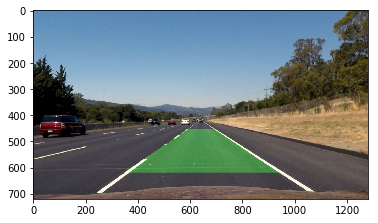

In [12]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
plt.imshow(result)
plt.savefig('./images/result.png')
plt.show()

## Pipeline

All methods needed to run the pipeline.

In [23]:
def calibrate_camera(calib_img_dir='./camera_cal/calibration*.jpg'):

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob(calib_img_dir)

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    return objpoints, imgpoints

def region_of_interest(img):
 
    shape = img.shape
    vertices = np.array([[(0,0),(shape[1],0),(shape[1],0),(6*shape[1]/7,shape[0]),
                      (shape[1]/7,shape[0]), (0,0)]],dtype=np.int32)

    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def undistort(img):
    result = cv2.undistort(img, mtx, dist, None, mtx)
    return result

def binarize(img, s_thresh=(120, 255), sx_thresh=(20, 255), l_thresh=(40,255)):
    img = np.copy(img)
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    #h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    # sobelx = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255))
    # l_channel_col=np.dstack((l_channel,l_channel, l_channel))
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold saturation channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Threshold lightness
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    channels = 255*np.dstack(( l_binary, sxbinary, s_binary)).astype('uint8')        
    binary = np.zeros_like(sxbinary)
    binary[((l_binary == 1) & (s_binary == 1) | (sxbinary==1))] = 1
    binary = 255*np.dstack((binary, binary, binary)).astype('uint8')            
    return  binary, channels

def warp(img, tobird=True):
    corners = np.float32([[190,720], [589,457], [698,457], [1145,720]])
    new_top_left = np.array([corners[0,0],0])
    new_top_right = np.array([corners[3,0],0])
    offset = [150,0]
    
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([corners[0], corners[1], corners[2], corners[3]])
    dst = np.float32([corners[0]+offset, new_top_left+offset, new_top_right-offset, corners[3]-offset])    
    if tobird:
        M = cv2.getPerspectiveTransform(src, dst)
    else:
        M = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(img, M, img_size , flags=cv2.INTER_LINEAR)    
    return warped, M


def find_peaks(img, thresh):
    img_half = img[int(img.shape[0]/2):,:,0]
    data = np.sum(img_half, axis=0)
    filtered = scipy.ndimage.filters.gaussian_filter1d(data, 20)
    xs = np.arange(len(filtered))
    peak_ind = signal.find_peaks_cwt(filtered, np.arange(20, 300))
    peaks = np.array(peak_ind)
    peaks = peaks[filtered[peak_ind] > thresh]
    return peaks, filtered


def get_next_window(img, center_point, width):
    
    ny,nx,_ = img.shape
    mask = np.zeros_like(img)
    if (center_point <= width/2): center_point = width/2
    if (center_point >= nx-width/2): center_point = nx-width/2
    
    left  = center_point - width/2
    right = center_point + width/2
    
    vertices = np.array([[(left, 0),(left, ny), (right, ny),(right, 0)]], dtype=np.int32)
    ignore_mask_color = (255, 255, 255)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked = cv2.bitwise_and(mask,img)

    hist = np.sum(masked[:,:,0],axis=0)
    if max(hist>10000):
        center = np.argmax(hist)
    else:
        center = center_point
        
    return masked, center

def lane_from_window(binary, center_point, width):
    n_zones = 6
    ny,nx,nc = binary.shape
    zones = binary.reshape(n_zones,-1,nx,nc)
    zones = zones[::-1] # start from the bottom slice
    window,center = get_next_window(zones[0], center_point, width)
    
    for zone in zones[1:]:
        next_window,center = get_next_window(zone, center, width)
        window = np.vstack((next_window,window))
    
    return window


# Define a class to receive the characteristics of each line detection
class Line:
    def __init__(self, n=5):
        # length of queue to store data
        self.n = n
        #number of fits in buffer
        self.n_buffered = 0
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = deque([],maxlen=n)
        #average x values of the fitted line over the last n iterations
        self.avgx = None
        # fit coeffs of the last n fits
        self.recent_fit_coeffs = deque([],maxlen=n)        
        #polynomial coefficients averaged over the last n iterations
        self.avg_fit_coeffs = None  
        # xvals of the most recent fit
        self.current_fit_xvals = [np.array([False])]  
        #polynomial coefficients for the most recent fit
        self.current_fit_coeffs = [np.array([False])]          
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        #y values for line fit
        self.fit_yvals = np.linspace(0, 100, num=101)*7.2  # always the same y-range as image
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        # origin (pixels) of fitted line at the bottom of the image
        self.line_pos = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
     
    def add_values(self):
        self.recent_xfitted.appendleft(self.current_fit_xvals)
        self.recent_fit_coeffs.appendleft(self.current_fit_coeffs)
        assert len(self.recent_xfitted)==len(self.recent_fit_coeffs)
        self.n_buffered = len(self.recent_xfitted)
        
    def clear_buffer(self):        
        if self.n_buffered > 0:
            self.recent_xfitted.pop()
            self.recent_fit_coeffs.pop()
            assert len(self.recent_xfitted)==len(self.recent_fit_coeffs)
            self.n_buffered = len(self.recent_xfitted)
        
        return self.n_buffered
        
    def set_avgx(self):
        fits = self.recent_xfitted
        if len(fits)>0:
            avg=0
            for fit in fits:
                avg +=np.array(fit)
            avg = avg / len(fits)
            self.avgx = avg
            
    def set_avgcoeffs(self):
        coeffs = self.recent_fit_coeffs
        if len(coeffs)>0:
            avg=0
            for coeff in coeffs:
                avg +=np.array(coeff)
            avg = avg / len(coeffs)
            self.avg_fit_coeffs = avg
                                      
            
    def set_line_base_pos(self):
        y_eval = max(self.fit_yvals)
        self.line_pos = self.current_fit_coeffs[0]*y_eval**2 \
                        +self.current_fit_coeffs[1]*y_eval \
                        + self.current_fit_coeffs[2]
        basepos = 640
        
        self.line_base_pos = (self.line_pos - basepos)*3.7/600.0 # 3.7 meters is about 600 pixels in the x direction

    # here come sanity checks of the computed metrics
    def accept_lane(self):
        flag = True
        maxdist = 2.8  # distance in meters from the lane
        if(abs(self.line_base_pos) > maxdist ):
            print('lane too far away')
            flag  = False        
        if(self.n_buffered > 0):
            relative_delta = self.diffs / self.avg_fit_coeffs
            # allow maximally this percentage of variation in the fit coefficients from frame to frame
            if not (abs(relative_delta)<np.array([0.7,0.5,0.15])).all():
                # print('fit coeffs too far off [%]',relative_delta)
                flag=False
                
        return flag
    
    def update(self, lane):
        
        self.ally, self.allx = (lane[:,:,0]>254).nonzero()
        
        self.current_fit_coeffs = np.polyfit(self.ally, self.allx, 2)
        yvals = self.fit_yvals
        self.current_fit_xvals = self.current_fit_coeffs[0]*yvals**2 + self.current_fit_coeffs[1]*yvals + self.current_fit_coeffs[2]
        
        y_eval = max(self.fit_yvals)
        if self.avg_fit_coeffs is not None:
            self.radius_of_curvature = ((1 + (2*self.avg_fit_coeffs[0]*y_eval + self.avg_fit_coeffs[1])**2)**1.5) \
                             /np.absolute(2*self.avg_fit_coeffs[0])
                
        y_eval = max(self.fit_yvals)
        self.line_pos = self.current_fit_coeffs[0]*y_eval**2 \
                        +self.current_fit_coeffs[1]*y_eval \
                        + self.current_fit_coeffs[2]
        basepos = 640
        
        self.line_base_pos = (self.line_pos - basepos)*3.7/600.0 # 3.7 meters is about 600 pixels in the x direction
        
        
        if self.n_buffered > 0:
            self.diffs = self.current_fit_coeffs - self.avg_fit_coeffs
        else:
            self.diffs = np.array([0,0,0], dtype='float')         
            
        if self.accept_lane():
            self.detected = True
            self.add_values()
            self.set_avgx()
            self.set_avgcoeffs()            
        else:
            self.detected = False            
            self.clear_buffer()
            if self.n_buffered > 0:
                self.set_avgx()
                self.set_avgcoeffs()
                    
        return self.detected, self.n_buffered

#######################################################
def get_binary_lane_image(img, line, window_center, width=300):
    if line.detected:
        window_center = line.line_pos
    else:
        peaks, filtered = find_peaks(img, thresh=3000)                       
            
        peak_ind = np.argmin(abs(peaks - window_center))
        peak  = peaks[peak_ind]
        window_center = peak
    
    lane_binary = lane_from_window(img, window_center, width)
    return lane_binary 


def project_lane_lines(img, left_fitx, right_fitx, yvals):
    
    # Create an image to draw the lines on
    color_warp = np.zeros_like(img).astype(np.uint8)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    undist = cal_undistort(img, objpoints, imgpoints)
    unwarp,Minv = warp(img,tobird=False)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result
        

class FindLanes:
    
    def __init__(self,):
        
        self.left = Line(7)
        self.right = Line(7)
        
        objpoints, imgpoints = calibrate_camera()
        self.objpoints = objpoints
        self.imgpoints = imgpoints

    def process_image(self, img):

        undist = cal_undistort(img, self.objpoints, self.imgpoints)
        binary,_  = binarize(undist)
        warped,_  = warp(binary)
        warped_binary = region_of_interest(warped)

        window_center_l = 340
        if self.left.detected:
            window_center_l = self.left.line_pos        
        left_binary = get_binary_lane_image(warped_binary, self.left, window_center_l, width=300)

        window_center_r = 940
        if self.right.detected:
            window_center_r = self.right.line_pos        
        right_binary = get_binary_lane_image(warped_binary, self.right, window_center_r, width=300)

        detected_l, n_buffered_left = self.left.update(left_binary)
        detected_r, n_buffered_right = self.right.update(right_binary)    

        left_fitx = self.left.avgx
        right_fitx = self.right.avgx
        yvals = self.left.fit_yvals
        lane_width = 3.7
        off_center = -100*round(0.5*(self.right.line_base_pos-lane_width/2) +  0.5*(abs(self.left.line_base_pos)-lane_width/2),2)

        result = project_lane_lines(img, left_fitx, right_fitx, yvals) 
        
        # Add text
        font = cv2.FONT_HERSHEY_DUPLEX
        distance_from_center = 'distance from center: {} cm'.format(math.ceil(off_center))
        cv2.putText(result, distance_from_center, (430,630), font, 1, (255,255,255), 2, cv2.LINE_AA)
        if self.left.radius_of_curvature and self.right.radius_of_curvature:
            curvature = math.ceil(0.5*(self.right.radius_of_curvature/1000 + self.left.radius_of_curvature/1000))
            radius_of_curvature = 'radius of curvature: {} km'.format(curvature)
            cv2.putText(result, radius_of_curvature, (430,670), font, 1, (255,255,255), 2, cv2.LINE_AA) 

        return result

find_lanes = FindLanes()

### Testing Images



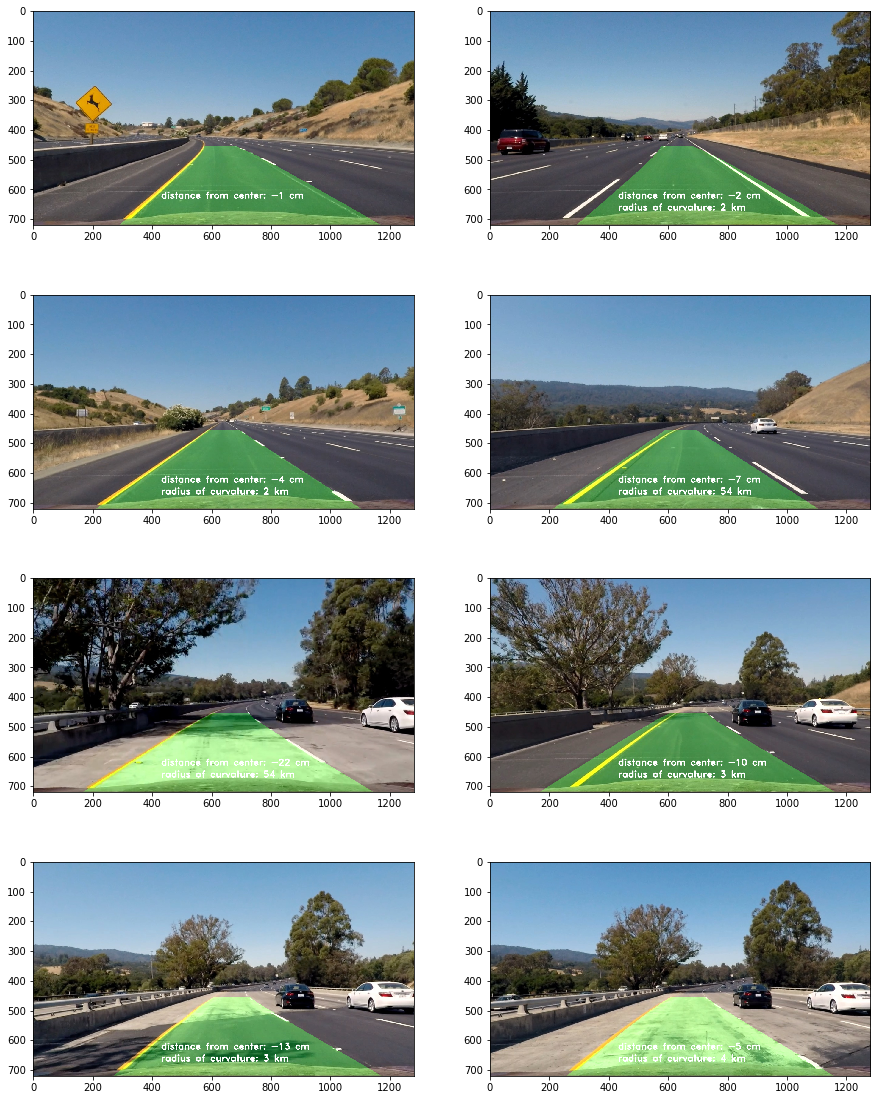

In [24]:
test_images_dir = './test_images'
test_images = os.listdir(test_images_dir)

fig, axes = plt.subplots(4, 2, figsize=(15,20))

i = 0
for row in axes:
    for col in row:
        
        img_path = test_images[i]
        image = cv2.imread(os.path.join(test_images_dir, img_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        output = find_lanes.process_image(image)
        col.imshow(output)
        i += 1

plt.savefig('./images/test_images.png')        
plt.show()

In [ ]:
video_file = 'bridge_shadow.mp4'
output_file = 'output_' + video_file


print('Processing video ...', video_file)
from moviepy.editor import VideoFileClip

clip2 = VideoFileClip(video_file)
vid_clip = clip2.fl_image(find_lanes.process_image)
vid_clip.write_videofile(output_file, audio=False)

In [25]:
video_file = 'project_video.mp4'
output_file = 'output_' + video_file


print('Processing video ...', video_file)
from moviepy.editor import VideoFileClip

clip2 = VideoFileClip(video_file)
vid_clip = clip2.fl_image(find_lanes.process_image)
vid_clip.write_videofile(output_file, audio=False)

Processing video ... project_video.mp4
[MoviePy] >>>> Building video output_project_video.mp4
[MoviePy] Writing video output_project_video.mp4



100%|█████████▉| 1260/1261 [1:23:33<00:04,  4.13s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_project_video.mp4 

